<a href="https://colab.research.google.com/github/AI-AmrIbrahim/ASL_Classifier_DL/blob/main/script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [2]:
!kaggle datasets download -d grassknoted/asl-alphabet

! unzip "asl-alphabet.zip"

Streaming output truncated to the last 5000 lines.
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing19.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1908.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1909.jpg  
  inflating: asl_alphabet_tr

In [29]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
import cv2

import torch
from torchvision import datasets, models
from torchvision.transforms import v2
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import confusion_matrix, classification_report

### Computing Custom Normalization
The numbers [0.485, 0.456, 0.406] for the mean and [0.229, 0.224, 0.225] for the standard deviation are standard values commonly used within the deep learning field. They come from the ImageNet dataset, a large-scale dataset used to train many pre-trained models (like ResNet, VGG, etc.).

Mean: [0.485, 0.456, 0.406] are the average values of the red, green, and blue channels, respectively, computed from millions of images.

Standard Deviation: [0.229, 0.224, 0.225] represents the typical variation in pixel intensity from the mean for each channel.

If your dataset is significantly different from natural images (e.g., medical images, satellite images), it might be more beneficial to compute your dataset's own mean and standard deviation.

Here I am computing custom normalization for fun.

In [30]:
# Load the dataset (train_loader could be your train set)
train_root = "/content/asl_alphabet_train/asl_alphabet_train"
train_dataset = datasets.ImageFolder(root = train_root, transform = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]))
loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
img, label = train_dataset[0]  # `img` is a PIL image
original_size = img.size()  # (width, height)

mean = 0.0
std = 0.0
nb_samples = 0.0

for data, _ in loader:
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

print(f"Original size of the image: {original_size}")
print("Mean: ", mean)
print("Std: ", std)


Original size of the image: torch.Size([3, 200, 200])
Mean:  tensor([0.5189, 0.4990, 0.5145])
Std:  tensor([0.2038, 0.2329, 0.2405])


### Data Augmentation
Data augmentation helps the model generalize better by artificially increasing the size and variability of the dataset. It introduces variations like random rotations, flips, or zooms to make the model more robust to real-world variations that might exist in hand sign images.

Normalization adjusts the pixel values to a common scale, typically helping with:

* Model Stability: Neural networks converge faster when inputs have a consistent scale.
* Better Training: Features with large differences in magnitude can make training harder, leading to suboptimal performance.

Augmentations used:
* RandomRotation
* ColorJitter
* RandomGrayScale
* Resize
* Normalize

In [31]:
# Augmentations for the training set
train_transforms = v2.Compose([
    v2.RandomRotation(degrees=(-15, 15)),  # Rotates the image by a random angle within the range of -15 to 15 degrees
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly adjusts brightness, contrast, saturation, and hue
    v2.RandomGrayscale(p=0.2),  # Converts the image to grayscale with a probability of 0.2
    v2.Resize((224, 224)),  # Resizes the image to 224x224 pixels
    v2.ToImage(),  # Converts the transformed image to PIL Image format
    v2.ToDtype(torch.float32, scale=True),  # Converts the image to torch.float32 and scales pixel values to [0, 1]
    v2.Normalize(mean, std)  # Normalizes the image using the calculated mean and standard deviation
])

# Transformations for the test/validation set
test_transforms = v2.Compose([
    v2.Resize((224, 224)),  # Resize to 224x224
    v2.ToImage(),  # Convert to image format
    v2.ToDtype(torch.float32, scale=True),  # Convert to float32 and scale
    v2.Normalize(mean, std)  # Normalize with the same mean and std
])

batch_size = 64  # Use 64 images per batch

### Loading Data

In [32]:
train_root = "/content/asl_alphabet_train/asl_alphabet_train"
train_dataset = datasets.ImageFolder(root = train_root, transform = train_transforms)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [33]:
# GPT Code -- Try to learn
# Test data directory
test_root = "/content/asl_alphabet_test/asl_alphabet_test"

# Initialize lists to store test images and their labels
test_images = []
test_labels = []

# Define the label mapping
label_mapping = {
    'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9,
    'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19,
    'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'nothing': 26, 'space': 27
}

# Loop through the test directory
for filename in os.listdir(test_root):
    if filename.endswith(".jpg"):  # Assuming all images are in .jpg format
        img_path = os.path.join(test_root, filename)
        image = Image.open(img_path)
        image = test_transforms(image)  # Apply transformations

        # Extract the label from the filename (e.g., A_test.jpg -> A)
        label_name = filename.split('_')[0]
        label = label_mapping.get(label_name)

        # Append image and label to lists
        test_images.append(image)
        test_labels.append(label)

# Convert lists to tensors
test_images = torch.stack(test_images)
test_labels = torch.tensor(test_labels)

# Create a TensorDataset and DataLoader for the test set
test_dataset = TensorDataset(test_images, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Test set: {len(test_images)} images")


Test set: 28 images


### Sample Image Inputs

In [34]:
classes = train_dataset.classes
print("Classes:", classes)

Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


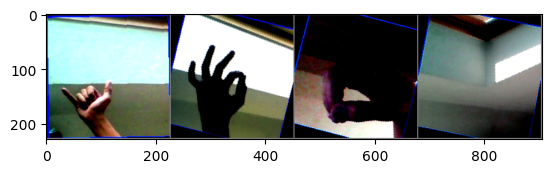

Y     F     P     nothing


In [35]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    npimg = np.clip(npimg, 0, 1) # clip values to be between 0 and 1
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(make_grid(images[0:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

### Model Architecture
Here I am considering couple approaches
* Custom CNN
* Transfer Learning using ResNet18

In [38]:
original_size

torch.Size([3, 200, 200])

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # input channels, output channels, kernel size
        self.pool = nn.MaxPool2d(2, 2)  # kernel size, stride
        self.conv2 = nn.Conv2d(6, 16, 5)

        # Calculate the size after convolutions and pooling
        # Assuming input image size is 128x128
        self.fc1_input_size = self._get_conv_output_size()
        print(f"FC1 Input Size: {self.fc1_input_size}")
        self.fc1 = nn.Linear(self.fc1_input_size, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 29)  # 29 classes (A-Z, nothing, space, del)

    def _get_conv_output_size(self):
        # Create a dummy input tensor with the same size as an image in your dataset
        with torch.no_grad():
            x = torch.zeros(1, 3, 224, 224)  # batch_size=1, channels=3, height=224, width=224
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            return x.numel()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

K     space U     H    
FC1 Input Size: 13456


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % len(train_loader) == len(train_loader) - 1:    # print at the end of each epoch
          print(f'[{epoch + 1}] loss: {running_loss / len(train_loader):.3f}')
          running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.669
[2,  2000] loss: 1.158
[3,  2000] loss: 0.578
[4,  2000] loss: 0.330
[5,  2000] loss: 0.226
[6,  2000] loss: 0.172
[7,  2000] loss: 0.132
[8,  2000] loss: 0.107
[9,  2000] loss: 0.084
[10,  2000] loss: 0.081
Finished Training


In [ ]:
PATH = 'asl_net.pth'
torch.save(net.state_dict(), PATH)

In [ ]:
net.eval()  # Set the model to evaluation mode

correct = 0
total = 0
with torch.no_grad():  # We don't need gradients for evaluation
    for inputs, labels in test_loader:
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct / total:.2f}%')

Accuracy of the network on the test images: 92.86%


In [ ]:
# Get predictions
y_true = []
y_pred = []

net.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = net(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# Classification report (F1-score, precision, recall)
print(classification_report(y_true, y_pred, target_names=classes))

asl_alphabet_test  asl_alphabet_train  asl-alphabet.zip  asl_net.pth  sample_data
